In [1]:
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import geopandas as gpd
import os

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

import sys
sys.path.append("..")
from channeling_lib import load_path
path=load_path()

terrain = plt.get_cmap('terrain')
terrain_truncated = truncate_colormap(terrain, 0.2, .9)

In [2]:
stations = pd.read_csv(path+'instrument_textbook_BLcourse_spring2025(BL instruments).csv', 
                       skipfooter=2, encoding='latin1')
# parse_dates=[['Setup time (UTC)','Retrieval time (UTC)','Maintenance start time (UTC)']])
stations['Setup time (UTC)'] = pd.to_datetime(stations['Setup time (UTC)'], format='%m/%d/%y %H:%M')
stations['Retrieval time (UTC)'] = pd.to_datetime(stations['Retrieval time (UTC)'], format='%m/%d/%y %H:%M')
stations['Maintenance start time (UTC)'] = pd.to_datetime(stations['Maintenance start time (UTC)'], format='%m/%d/%y %H:%M')
stations

/tmp/ipykernel_207969/1203934403.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  stations = pd.read_csv(path+'instrument_textbook_BLcourse_spring2025(BL instruments).csv',


Station name    Category Setup by group  \
0               Layla       AWS-P              3   
1                 TH3     Tinytag              3   
2                 TH2     Tinytag              3   
3            Tom Joad         AWS              3   
4                CEB5    TinyTag               3   
5             Rosanna       AWS-P              3   
6                CEB1    TinyTag               3   
7                 TH5     Tinytag              3   
8         Bette Davis         AWS              3   
9                CEB2    TinyTag               3   
10                TH6     Tinytag              3   
11       Mrs Robinson         AWS              3   
12               CEB4    TinyTag               3   
13                TH1    TinyTag               1   
14               TT12     Tinytag              4   
15               TT12     Tinytag              4   
16        Sonic-Fjord       Sonic              4   
17   Radiometer-Fjord  Radiometer              4   
18  CEB3-Ground-Fjord     Tinytag              4   
19        TT18-Valley     Tinytag           1, 4   
20        TT18-Valley     Tinytag           1, 4   
21             Stacy        Sonic           1, 4   
22                TH8     Tinytag              4   
23          MaggieMay     Sonic 1              1   
24          MaggieMay     Sonic 2              1   
25          MaggieMay      Temp 1              1   
26          MaggieMay      Temp 2              1   
27          MaggieMay   WindYoung              1   
28          MaggieMay       Wind               1   
29         TT16-slope    TinyTag               1   
30         TT16-slope    TinyTag               1   

            Quantities measured   LAT (dec deg)  LON (dec deg)  \
0                   T, Ws, Wd, P      78.172686      16.010102   
1                          T, Rh      78.181669      15.908088   
2                          T, Rh      78.212169      15.756418   
3                      T, Ws, Wd      78.226178      15.650295   
4                             Tg      78.226178      15.650295   
5                   T, Ws, Wd, P      78.239350      15.749290   
6                             Tg      78.239350      15.749290   
7                          T, Rh      78.223609      15.797014   
8                      T, Ws, Wd      78.213555      15.857184   
9                             Tg      78.213555      15.857184   
10                         T, Rh      78.197500      15.959215   
11                     T, Ws, Wd      78.192157      16.029810   
12                            Tg      78.192157      16.029810   
13                         T, Rh      78.240911      15.354190   
14                             T      78.248920      15.516820   
15                             T      78.248920      15.516820   
16                Ws, Wd, W_vert      78.248920      15.516860   
17  SW_in, SW_out, LW_in, LW_out      78.249020      15.516440   
18                             T      78.249020      15.516440   
19                             T      78.226423      15.322590   
20                             T      78.226423      15.322590   
21                   Ws, Wd, T_s      78.226423      15.322590   
22                         T, Rh      78.234830      15.555100   
23                   Ws, Wd, T_s      78.226651      15.327469   
24                   Ws, Wd, T_s      78.226651      15.327469   
25                             T      78.226651      15.327469   
26                             T      78.226651      15.327469   
27                       Ws, Wd       78.226651      15.327469   
28                            Ws      78.226651      15.327469   
29                             T      78.226651      15.327469   
30                             T      78.226651      15.327469   

   elevation from GPS (masl)  elevation from DEM (masl)  Radiometer height(m)  \
0         186 (NOT ACCURATE)                       28.2                   NaN   
1         181 (NOT ACCURATE)                       20.9              

In [3]:
seklima_stations = {'SN99870':{'name':'Adventdalen',
                       'id':'SN99870',
                       'elevation': 15,
                       'latitude':78.2022,
                       'longitude':15.831,
                       'valley_orientation':304%180},
            'SN99864':{'name':'Nybyen',
                       'id':'SN99864',
                       'elevation': 114,
                       'latitude':78.201609,
                       'longitude':15.59266,
                       'valley_orientation':30}, # degrees from north
             'SN99858':{'name':'Vannledningsdalen',
                       'id':'SN99858',
                       'elevation': 70,
                       'latitude':78.2128,
                       'longitude':15.633,
                       'valley_orientation':31},
            'SN99840':{'name':'Svalbard Lufthavn',
                       'id':'SN99840',
                       'elevation': 28,
                       'latitude':78.2453,
                       'longitude':15.5015,
                       'valley_orientation':305%180}, 
            'SN99843':{'name':'Platåberget III',
                       'id':'SN99843',
                       'elevation': 450,
                       'latitude':78.2278,
                       'longitude':15.378,
                       'valley_orientation':None}, 
            'SN99857':{'name':'LYR Central',
                       'id':'SN99857',
                       'elevation': 52,
                       'latitude':78.2127,
                       'longitude':15.6107,
                       'valley_orientation':32} }

## DEM

In [4]:
compute = False
if compute:
    fnames = ! ls /home/clc/Desktop/svalbard_DEM/*/*.tif
    for fn in fnames:
        ds = rxr.open_rasterio(fn).rio.reproject('EPSG:4326')
        print(fn.split('/')[-1]+': ', [ds.x.data.min(), ds.x.data.max(), ds.y.data.min(), ds.y.data.max()])

Potential ones:
- S0_DTM2_5_2009_13835_33_Longyearbyenomr
- S0_DTM5_2011_25162_33

In [5]:
DEM = rxr.open_rasterio(path+'DEM/NPI_DEM/DEM_AGF350.tif').squeeze()

## More pretty stuff

/home/clc/micromamba/envs/rxr/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  return ogr_read(
/home/clc/micromamba/envs/rxr/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  return ogr_read(
/home/clc/micromamba/envs/rxr/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  return ogr_read(
/home/clc/micromamba/envs/rxr/lib/python3.12/site-packages/pyogrio/raw.py:196: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  return ogr_read(
/home/clc/micromamba/envs/rxr/lib/python3.12/site-packages/pyogrio/raw.p

(78.15, 78.26)

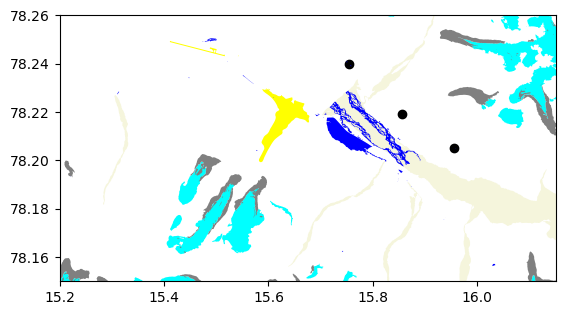

In [6]:
fig, ax = plt.subplots()

flood_plains = gpd.read_file(path+'DEM/NPI_DEM/1-100000_map/NP_S100_SHP/S100_Elvesletter_f.shp'
                            ).force_2d().to_crs('EPSG:4326')
flood_plains.plot(ax=ax, color='beige')

glaciers = gpd.read_file(path+'DEM/NPI_DEM/1-100000_map/NP_S100_SHP/S100_Isbreer_f.shp'
                            ).force_2d().to_crs('EPSG:4326')
glaciers.plot(ax=ax, color='cyan')

moraine = gpd.read_file(path+'DEM/NPI_DEM/1-100000_map/NP_S100_SHP/S100_Morener_f.shp'
                            ).force_2d().to_crs('EPSG:4326')
moraine.plot(ax=ax, color='grey')

pingos = gpd.read_file(path+'DEM/NPI_DEM/1-100000_map/NP_S100_SHP/S100_Pingoer_p.shp'
                            ).force_2d().to_crs('EPSG:4326')
pingos.plot(ax=ax, color='k')

city = gpd.read_file(path+'DEM/NPI_DEM/1-100000_map/NP_S100_SHP/S100_TekniskSituasjon_f.shp'
                            ).force_2d().to_crs('EPSG:4326')
city.plot(ax=ax, color='yellow')
   
lake = gpd.read_file(path+'DEM/NPI_DEM/1-100000_map/NP_S100_SHP/S100_Vann_f.shp'
                            ).force_2d().to_crs('EPSG:4326')
lake.plot(ax=ax, color='blue')


#ax.set_xlim(505_000, 540_000)
#ax.set_ylim(8.67e6, 8.69e6)

ax.set_xlim(15.2, 16.15)
ax.set_ylim(78.15, 78.26)

## Plot

/tmp/ipykernel_207969/2123040807.py:5: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(*np.meshgrid(DEM.x, DEM.y), DEM.data.squeeze(), levels=np.arange(0, 1000, 50), color='grey', alpha=.3)


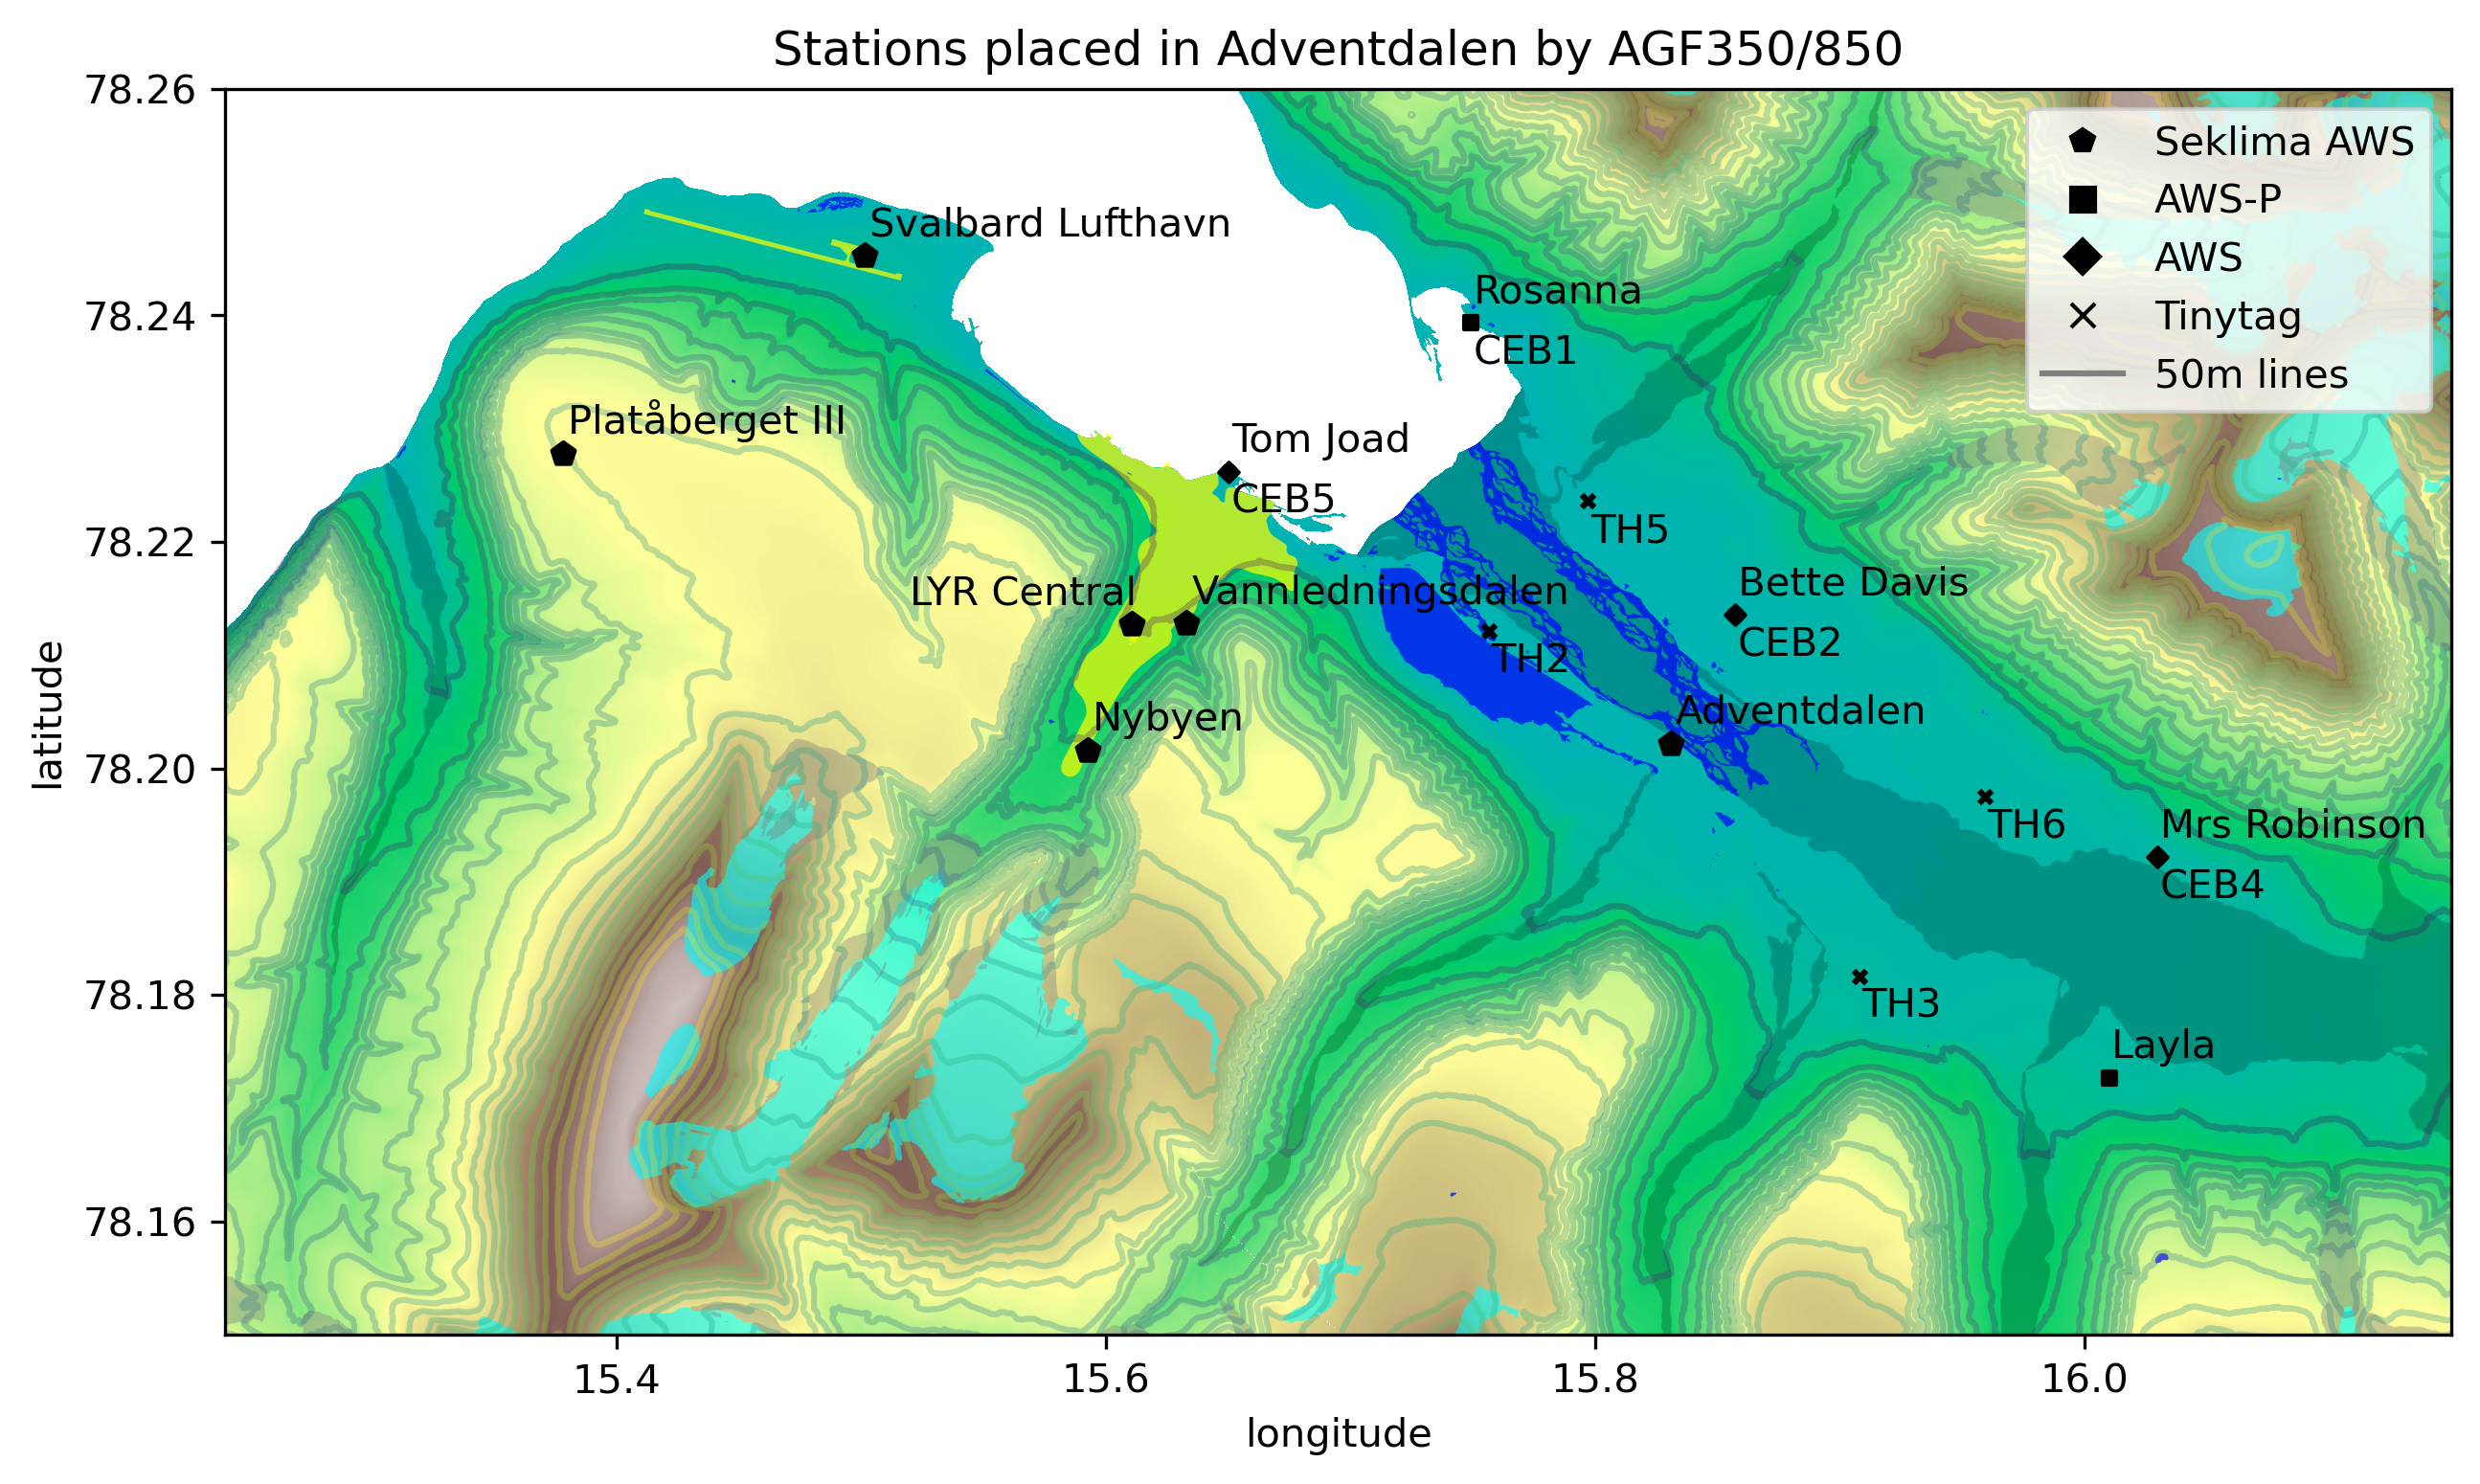

In [8]:
fig,ax = plt.subplots(figsize=(10,6), dpi=300)

DEM.plot(ax=ax, cmap=terrain_truncated, vmin=0, vmax=1050, add_colorbar=False)# cbar_kwargs={'label': "Elevation (masl)"})

ax.contour(*np.meshgrid(DEM.x, DEM.y), DEM.data.squeeze(), levels=np.arange(0, 1000, 50), color='grey', alpha=.3)

for i in range(len(stations)):
    
    row = stations.iloc[i]
    ms=12
    
    up = 1
    annotate=True if str(row['Setup by group']).replace(" ","")=="3" else False
    
    if row.Category.lower()=='aws-p': 
        marker='s' #square
        #c='b'
    elif row.Category.lower()=='aws': 
        marker='D' #diamond
        #c='m'
    elif row.Category.lower().replace(" ","")=='tinytag': 
        marker='x' #filled x
        up=-1
        ms = 10
        #c='orange'

    
    if annotate:
        ax.scatter(row['LON (dec deg)'], row['LAT (dec deg)'], marker=marker, c='k', s=ms, zorder=12)
        if up==-1: 
            va='top'
        else: 
            va='bottom'
        ax.annotate(row['Station name'], xy = [row['LON (dec deg)'], row['LAT (dec deg)']],
                    xytext=[row['LON (dec deg)']+.001, row['LAT (dec deg)']+.001*up], va=va)


for i, station_id in enumerate(list(seklima_stations.keys())):
    va = 'bottom' if i%2==0 else 'top'
    if seklima_stations[station_id]['name'] =='LYR Central':
        ax.scatter(seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude'], marker='p', c='k', zorder=15)
        ax.annotate(seklima_stations[station_id]['name'], 
                    xy = [seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude']],
                    xytext=[seklima_stations[station_id]['longitude']+.002, seklima_stations[station_id]['latitude']+.001],
                    va='bottom', ha='right')

    else:
        ax.scatter(seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude'], marker='p', c='k', zorder=15)
        ax.annotate(seklima_stations[station_id]['name'], 
                    xy = [seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude']],
                    xytext=[seklima_stations[station_id]['longitude']+.002, seklima_stations[station_id]['latitude']+.001],
                    va='bottom', ha='left')

ax.legend([Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='p'),
           Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='s'),
           Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='D'),
           Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='x'),
          Line2D([0], [0], c='grey')],
          ['Seklima AWS', 'AWS-P', 'AWS','Tinytag', '50m lines'], loc='upper right')

flood_plains.plot(ax=ax, color='k', alpha=.2)
glaciers.plot(ax=ax, color='cyan', alpha=.6)
moraine.plot(ax=ax, color='grey', alpha=.4)
#pingos.plot(ax=ax, color='k')
city.plot(ax=ax, color='yellow', alpha=.7)
lake.plot(ax=ax, color='blue', alpha=.7)

ax.set_xlim(15.24, 16.15)
ax.set_ylim(78.15, 78.26)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_title('Stations placed in Adventdalen by AGF350/850')
plt.savefig('../figs/map.png')
plt.show()



# Now add the model resolutions

In [9]:
AROME_grid = xr.open_dataset(load_path()+'ModelOutput/AromeArctic/AA_static_fields_2p5km.nc')
IFS_grid = xr.open_dataset(load_path()+'ModelOutput/IFS/IFS_20250122.nc')
X_IFS, Y_IFS = np.meshgrid(IFS_grid.longitude, IFS_grid.latitude)

/tmp/ipykernel_207969/3060727355.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(AROME_grid.longitude, AROME_grid.latitude, np.ones_like(AROME_grid.latitude), alpha=.1, color='k')#, marker='1', c='k')


(78.15, 78.26)

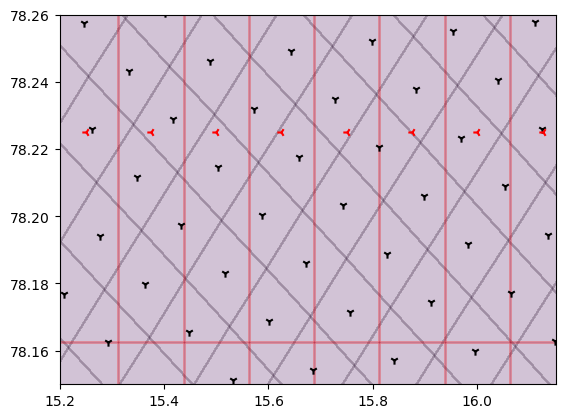

In [10]:
plt.pcolormesh(AROME_grid.longitude, AROME_grid.latitude, np.ones_like(AROME_grid.latitude), alpha=.1, color='k')#, marker='1', c='k')
plt.pcolormesh(X_IFS, Y_IFS, np.ones_like(X_IFS), alpha=.15, color='r')#, marker='3', c='r')
plt.scatter(AROME_grid.longitude, AROME_grid.latitude, marker='1', c='k')
plt.scatter(X_IFS, Y_IFS, marker='3', c='r')
plt.xlim(15.2, 16.15)
plt.ylim(78.15, 78.26)

In [11]:
def create_marker_with_patch(marker, color):
    patch = Patch(facecolor=color, alpha=.1)
    line = Line2D([0], [0], marker=marker, markerfacecolor=color, markeredgecolor=color, lw=0)
    return (patch, line)

/tmp/ipykernel_207969/880827178.py:5: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(*np.meshgrid(DEM.x, DEM.y), DEM.data.squeeze(), levels=np.arange(0, 1000, 50), color='grey', alpha=.3)
/tmp/ipykernel_207969/880827178.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(AROME_grid.longitude, AROME_grid.latitude, np.ones_like(AROME_grid.latitude), alpha=.1, color='k')#, marker='1', c='k')


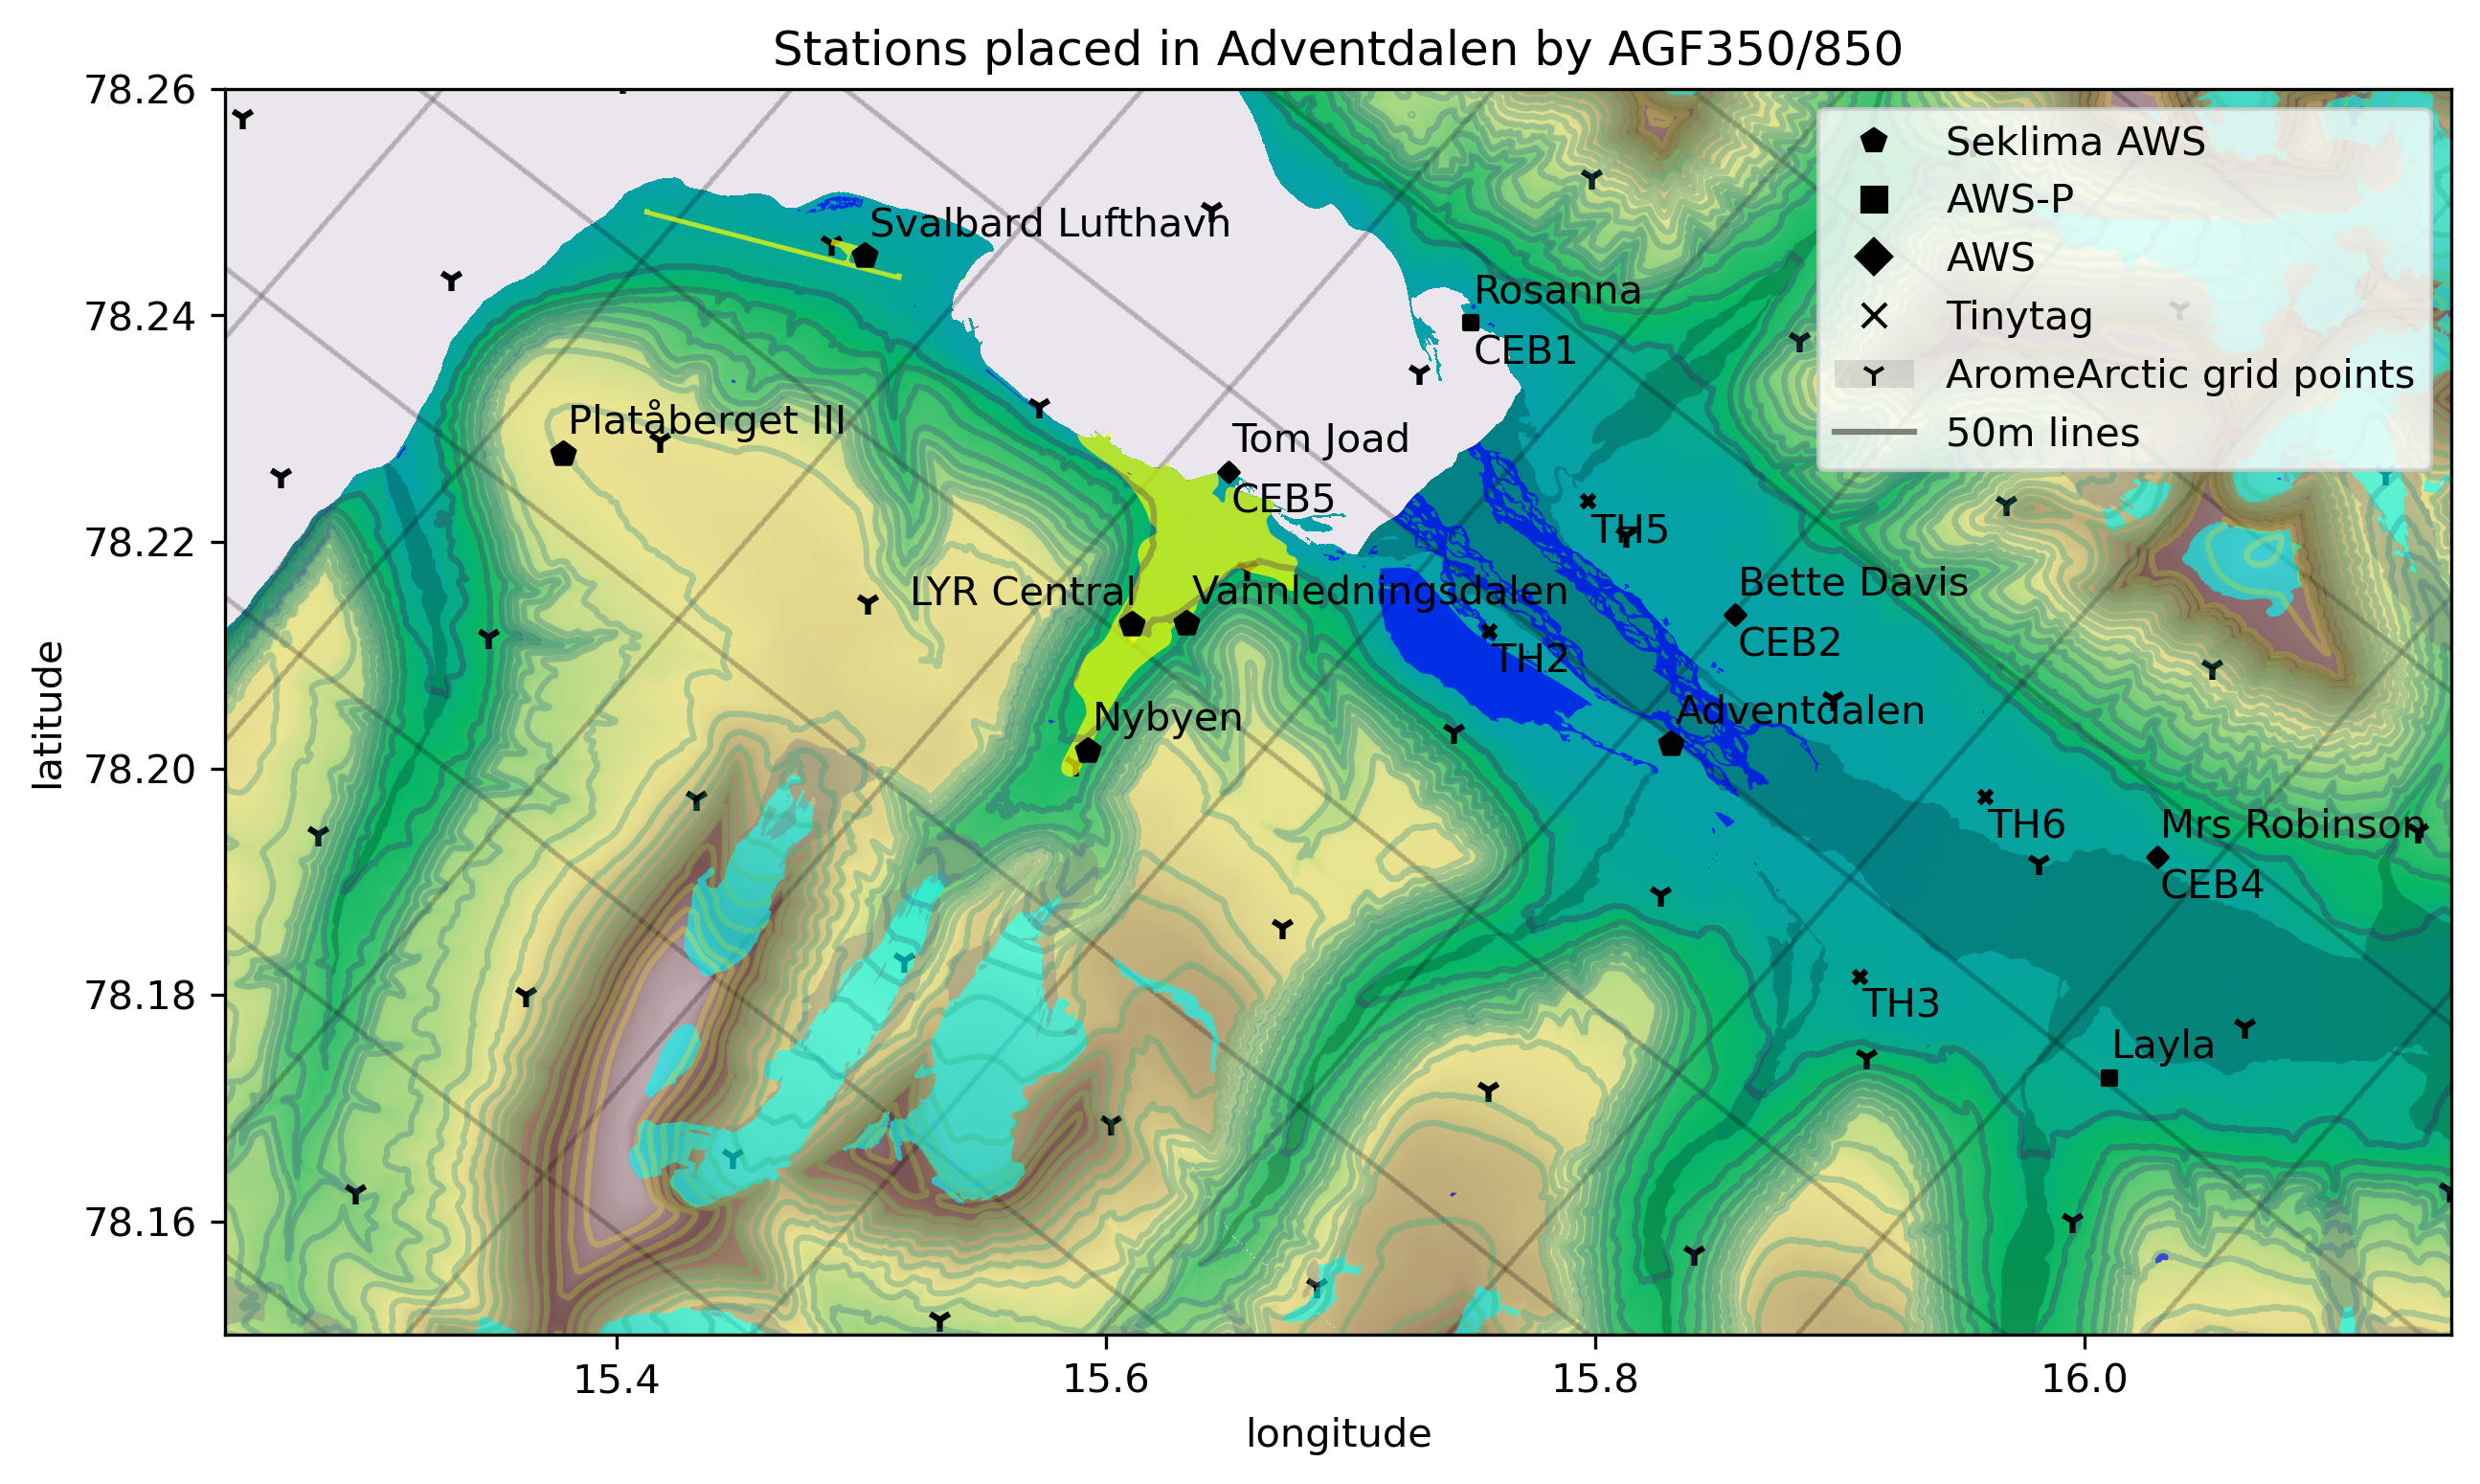

In [14]:
fig,ax = plt.subplots(figsize=(10,6), dpi=300)

DEM.plot(ax=ax, cmap=terrain_truncated, vmin=0, vmax=1050, add_colorbar=False)# cbar_kwargs={'label': "Elevation (masl)"})

ax.contour(*np.meshgrid(DEM.x, DEM.y), DEM.data.squeeze(), levels=np.arange(0, 1000, 50), color='grey', alpha=.3)

for i in range(len(stations)):
    
    row = stations.iloc[i]
    ms=12
    
    up = 1
    annotate=True if str(row['Setup by group']).replace(" ","")=="3" else False
    
    if row.Category.lower()=='aws-p': 
        marker='s' #square
        #c='b'
    elif row.Category.lower()=='aws': 
        marker='D' #diamond
        #c='m'
    elif row.Category.lower().replace(" ","")=='tinytag': 
        marker='x' #filled x
        up=-1
        ms = 10
        #c='orange'

    
    if annotate:
        ax.scatter(row['LON (dec deg)'], row['LAT (dec deg)'], marker=marker, c='k', s=ms, zorder=12)
        if up==-1: 
            va='top'
        else: 
            va='bottom'
        ax.annotate(row['Station name'], xy = [row['LON (dec deg)'], row['LAT (dec deg)']],
                    xytext=[row['LON (dec deg)']+.001, row['LAT (dec deg)']+.001*up], va=va)


for i, station_id in enumerate(list(seklima_stations.keys())):
    va = 'bottom' if i%2==0 else 'top'
    if seklima_stations[station_id]['name'] =='LYR Central':
        ax.scatter(seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude'], marker='p', c='k', zorder=15)
        ax.annotate(seklima_stations[station_id]['name'], 
                    xy = [seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude']],
                    xytext=[seklima_stations[station_id]['longitude']+.002, seklima_stations[station_id]['latitude']+.001],
                    va='bottom', ha='right')

    else:
        ax.scatter(seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude'], marker='p', c='k', zorder=15)
        ax.annotate(seklima_stations[station_id]['name'], 
                    xy = [seklima_stations[station_id]['longitude'], seklima_stations[station_id]['latitude']],
                    xytext=[seklima_stations[station_id]['longitude']+.002, seklima_stations[station_id]['latitude']+.001],
                    va='bottom', ha='left')


ax.pcolormesh(AROME_grid.longitude, AROME_grid.latitude, np.ones_like(AROME_grid.latitude), alpha=.1, color='k')#, marker='1', c='k')
#ax.pcolormesh(X_IFS, Y_IFS, np.ones_like(X_IFS), alpha=.15, color='r')#, marker='3', c='r')
ax.scatter(AROME_grid.longitude, AROME_grid.latitude, marker='1', c='k')
#ax.scatter(X_IFS, Y_IFS, marker='3', c='r')

ax.legend([Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='p'), 
           Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='s'),
           Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='D'),
           Line2D([0], [0], markerfacecolor='k', markeredgecolor='k', lw=0, marker='x'),
           create_marker_with_patch('1', 'k'),
           #create_marker_with_patch('3', 'r'),
          Line2D([0], [0], c='grey')],
          ['Seklima AWS', 'AWS-P', 'AWS','Tinytag', 'AromeArctic grid points',#'IFS grid points',
           '50m lines'], loc='upper right')

flood_plains.plot(ax=ax, color='k', alpha=.2)
glaciers.plot(ax=ax, color='cyan', alpha=.6)
moraine.plot(ax=ax, color='grey', alpha=.4)
#pingos.plot(ax=ax, color='k')
city.plot(ax=ax, color='yellow', alpha=.7)
lake.plot(ax=ax, color='blue', alpha=.7)

ax.set_xlim(15.24, 16.15)
ax.set_ylim(78.15, 78.26)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_title('Stations placed in Adventdalen by AGF350/850')
plt.savefig('../figs/map_with_model_grids.png')
plt.show()



## Lighter version

/tmp/ipykernel_136178/279100891.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(AROME_grid.longitude, AROME_grid.latitude, np.ones_like(AROME_grid.latitude), alpha=.1, color='k')#, marker='1', c='k')


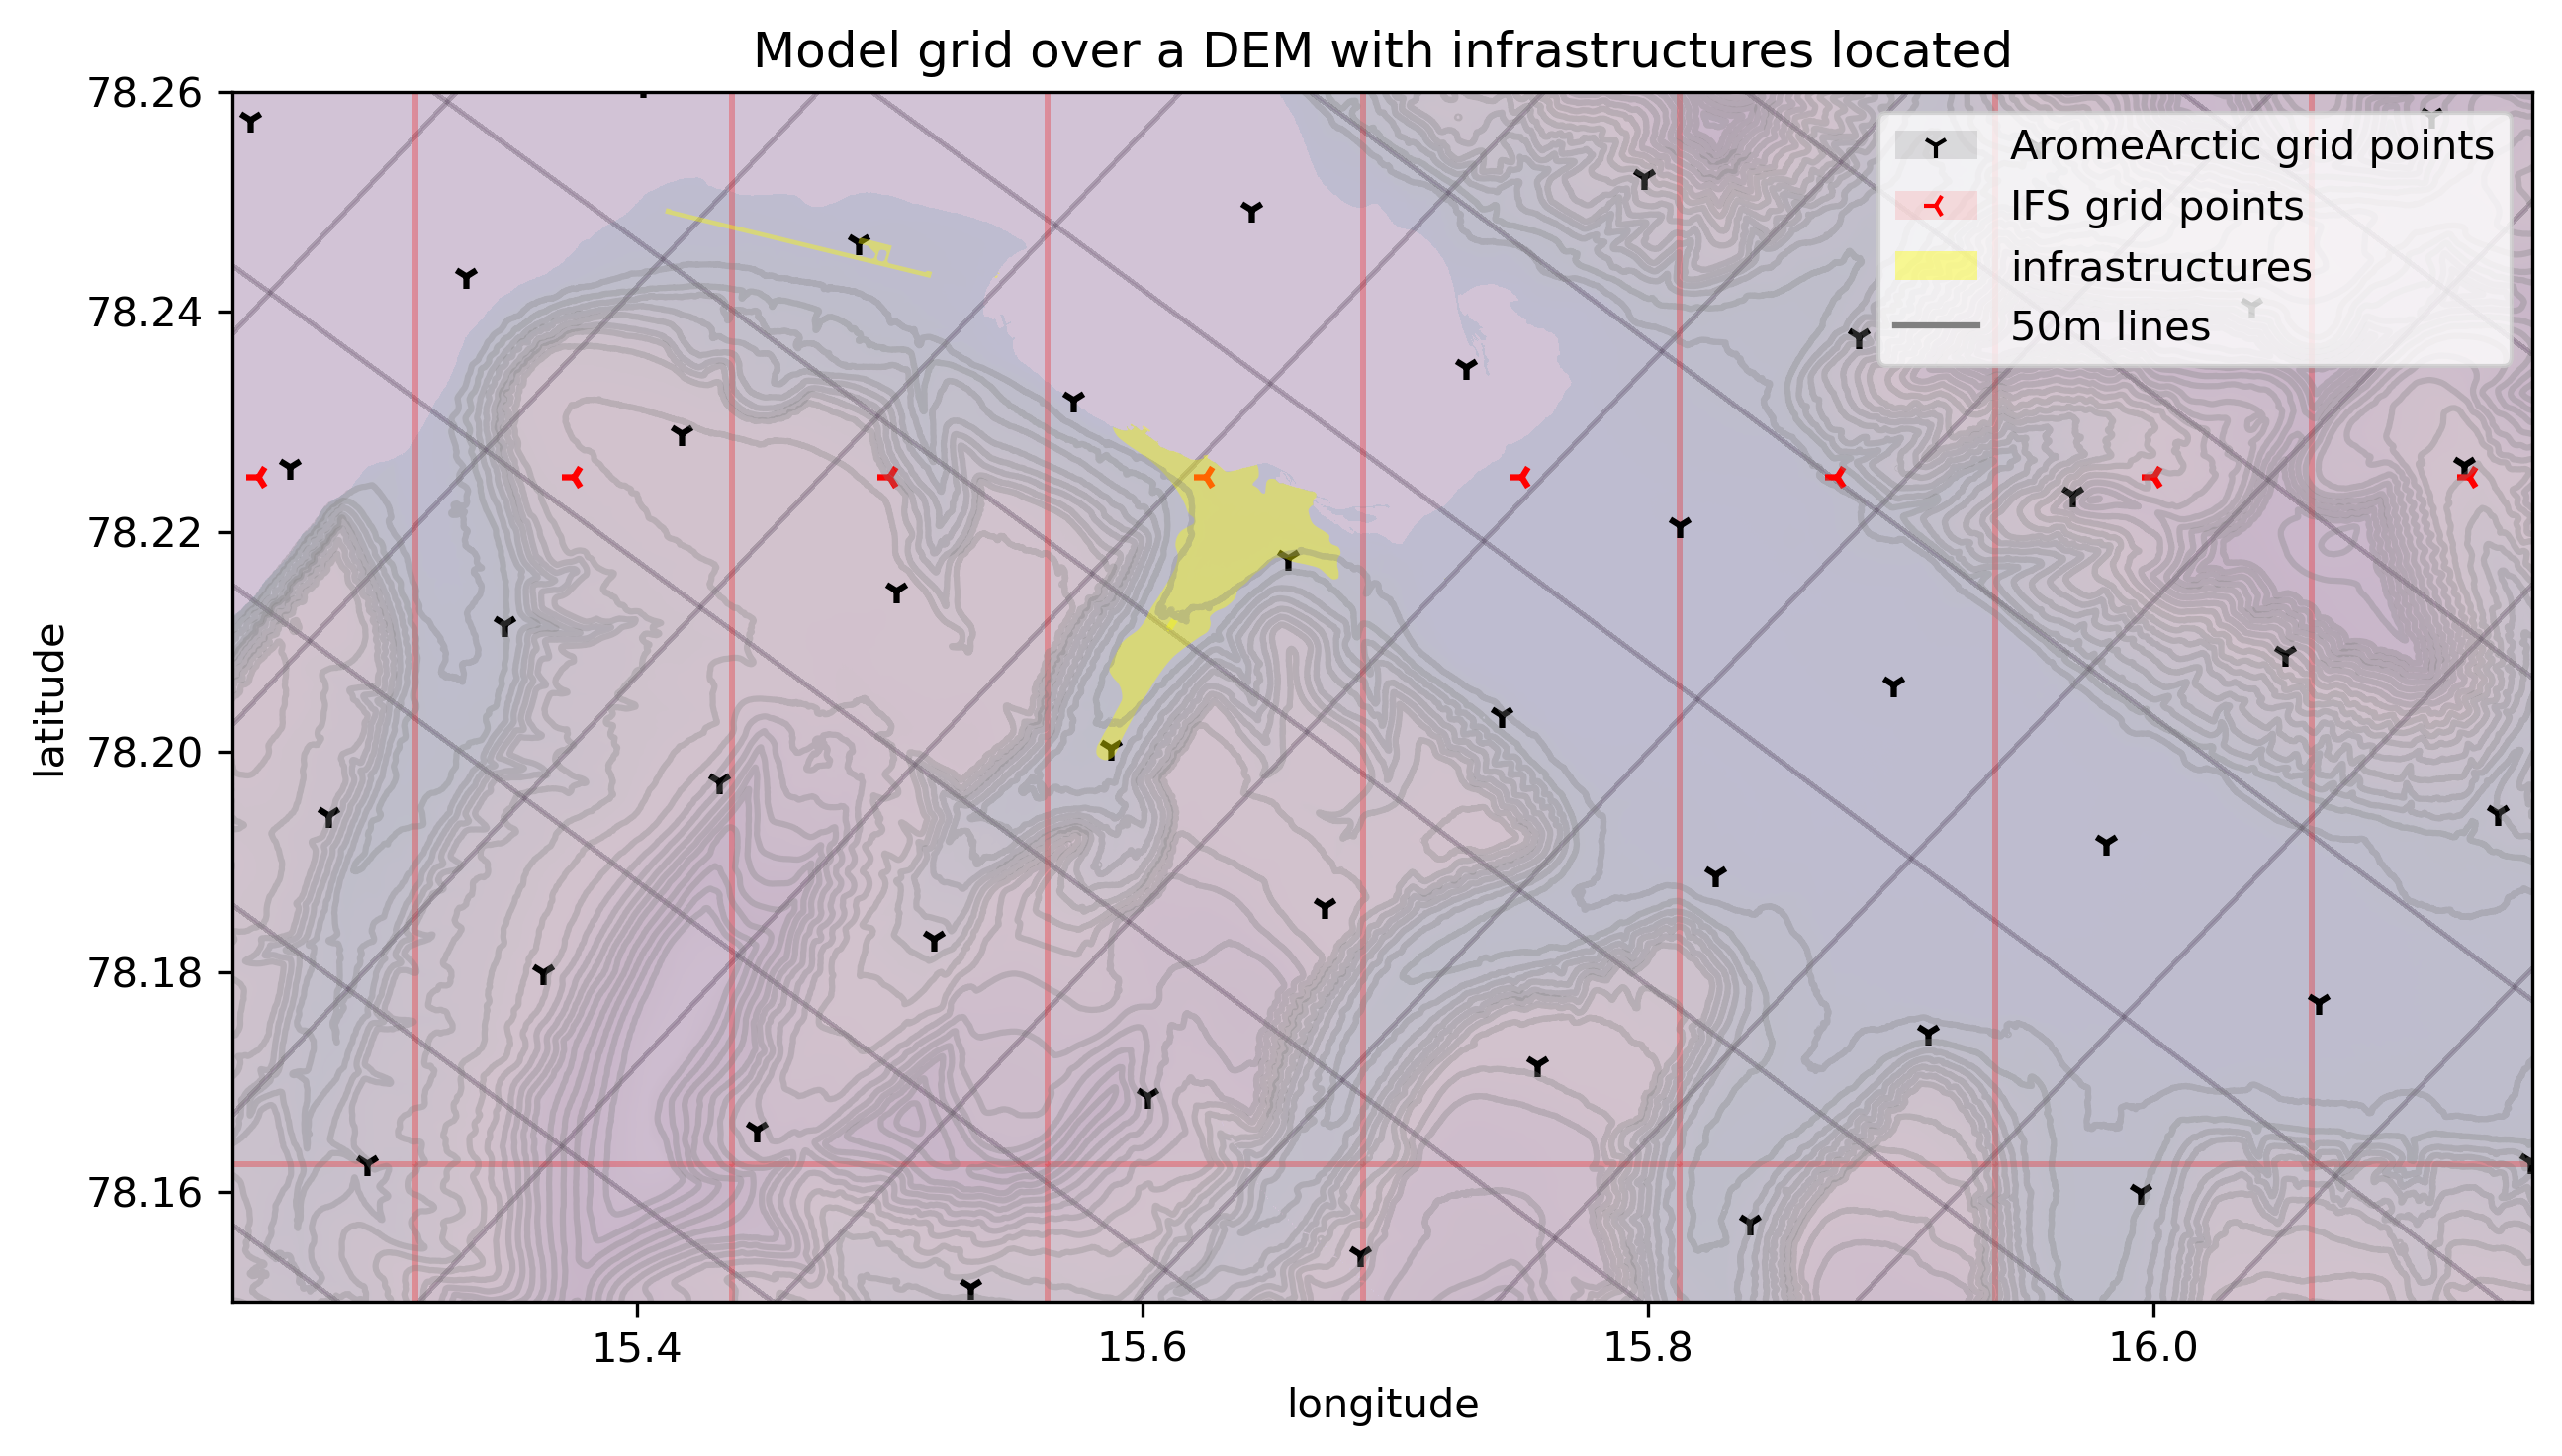

In [11]:
fig,ax = plt.subplots(figsize=(10,6), dpi=300)

DEM.where(~np.isnan(DEM)).plot(ax=ax, cmap=terrain_truncated, alpha=.1, add_colorbar=False)# cbar_kwargs={'label': "Elevation (masl)"})

ax.contour(*np.meshgrid(DEM.x, DEM.y), DEM.data.squeeze(), levels=np.arange(0, 1000, 50), colors='gray', alpha=.3)
ax.contour(*np.meshgrid(DEM.x, DEM.y), DEM.data.squeeze(), levels=[0], colors='gray', alpha=.3)

ax.pcolormesh(AROME_grid.longitude, AROME_grid.latitude, np.ones_like(AROME_grid.latitude), alpha=.1, color='k')#, marker='1', c='k')
ax.pcolormesh(X_IFS, Y_IFS, np.ones_like(X_IFS), alpha=.15, color='r')#, marker='3', c='r')
ax.scatter(AROME_grid.longitude, AROME_grid.latitude, marker='1', c='k')
ax.scatter(X_IFS, Y_IFS, marker='3', c='r')

ax.legend([create_marker_with_patch('1', 'k'),
           create_marker_with_patch('3', 'r'),
           Patch(facecolor='yellow', alpha=.4),
          Line2D([0], [0], c='grey')],
          ['AromeArctic grid points','IFS grid points', 'infrastructures', '50m lines'], loc='upper right')

#flood_plains.plot(ax=ax, color='k', alpha=.2)
#glaciers.plot(ax=ax, color='cyan', alpha=.6)
#moraine.plot(ax=ax, color='grey', alpha=.4)
#pingos.plot(ax=ax, color='k')
city.plot(ax=ax, color='yellow', alpha=.4)
#lake.plot(ax=ax, color='blue', alpha=.7)

ax.set_xlim(15.24, 16.15)
ax.set_ylim(78.15, 78.26)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

ax.set_title('Model grid over a DEM with infrastructures located')
plt.savefig('../figs/map_with_model_grids_LIGHT.png')
plt.show()

